In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# image path
image_path = 'images/corvette-moire-pattern.tif'

# read image
img = cv.imread(image_path)

# Check if the image was successfully loaded
if img is None:
    print("Error: Could not load image.")
else:
    print("Image loaded successfully.")

Image loaded successfully.


Image shape: (246, 168, 3)
Image Gray Shape: (246, 168)


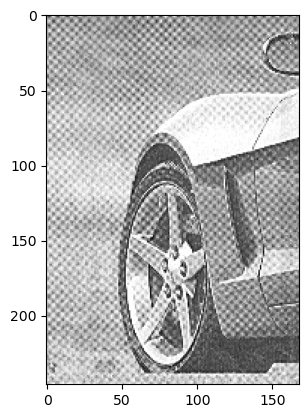

In [4]:
# Display the image
print("Image shape:", img.shape)

img_gry = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


print("Image Gray Shape:", img_gry.shape)
# Convert the image from BGR to RGB color space
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

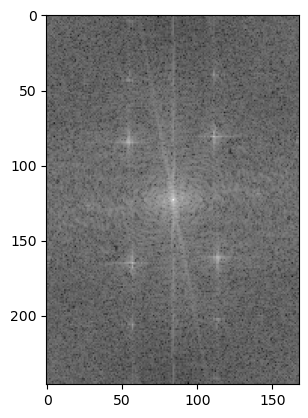

In [5]:
img_gray = np.float32(img_gry)

img_dft = cv.dft(img_gray, flags=cv.DFT_COMPLEX_OUTPUT)

img_dft_shift = np.fft.fftshift(img_dft)

img_magnitude_spectrum = np.log(1 + cv.magnitude(img_dft_shift[:,:,0], img_dft_shift[:,:,1]))

plt.imshow(img_magnitude_spectrum, cmap='gray')
plt.show()

C:\Users\mesfahani1\AppData\Local\Temp\ipykernel_5580\1978254163.py:24: RuntimeWarning: divide by zero encountered in divide
  H_notch = 1 / (1 + (radius**2 / (Dk * Dk))**n)


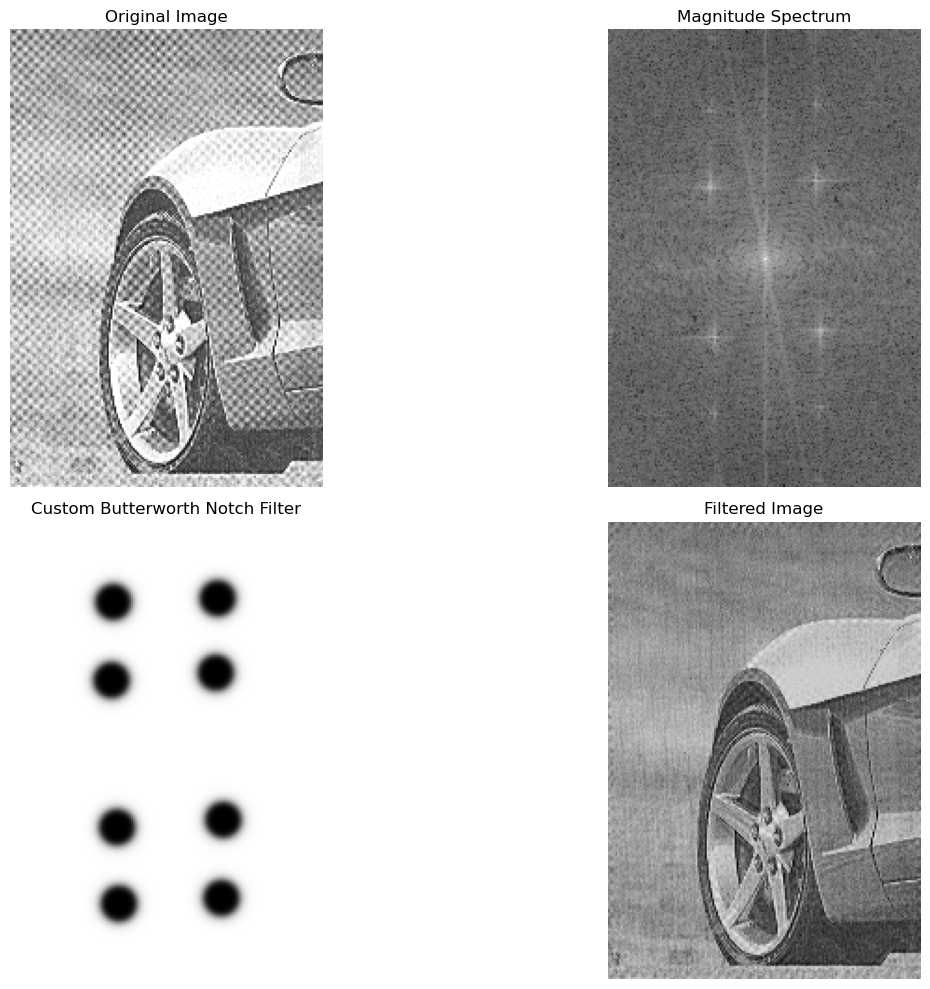

In [ ]:
def butterworth_notch_reject(shape, notch_params, n=4):
    
    M, N = shape
    H = np.ones((M, N))
    
    # Create coordinate grid
    u = np.arange(M)
    v = np.arange(N)
    U, V = np.meshgrid(u-M//2, v-N//2, indexing='ij')
    
    for uk, vk, diameter in notch_params:
        # Calculate distance from the notch center
        Dk = np.sqrt((U - uk)**2 + (V - vk)**2)
        
        # Create notch
        radius = diameter / 2
        H_notch = 1 / (1 + (radius**2 / (Dk * Dk))**n)
        H *= H_notch

    return H

# Example usage:
rows, cols = img_gray.shape

# Define notch parameters: (x, y, diameter)
notch_params = [
    (-80, -29, 20),     
    (-82, 27, 20),    
    (-42, 26, 20),     
    (-38, -30, 20),    
    (41, -27, 20),    
    (37, 30, 20), 
    (79, 29, 20),   
    (82, -26, 20)   
]

# Create the filter
H = butterworth_notch_reject((rows, cols), notch_params, n=4)

# Apply filter
mask_complex = np.stack([H, H], axis=-1)
filtered_dft = img_dft_shift * mask_complex

# Inverse shift and DFT
filtered_shift = np.fft.ifftshift(filtered_dft)
img_filtered = cv.idft(filtered_shift)
img_filtered = cv.magnitude(img_filtered[:,:,0], img_filtered[:,:,1])

# Normalize result
img_filtered = cv.normalize(img_filtered, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)


plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(img_gry, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(222)
magnitude_spectrum = np.log(1 + cv.magnitude(img_dft_shift[:,:,0], img_dft_shift[:,:,1]))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')

plt.subplot(223)
plt.imshow(H, cmap='gray')
plt.title('Custom Butterworth Notch Filter')
plt.axis('off')

plt.subplot(224)
plt.imshow(img_filtered, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()